In [1]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt

# Генерация данных

In [2]:
#Упражнение 1
def generate_x_y_data_v1(isTrain,batch_size):
    seq_length = 10
    batch_x = []
    batch_y = []
  
    for _ in range(batch_size):
        rand = random.random() * 2 * math.pi

        sig1 = np.sin(np.linspace(0.0 * math.pi + rand,
                                  3.0 * math.pi + rand,seq_length * 2))
        sig2 = np.cos(np.linspace(0.0 * math.pi + rand,
                                  3.0 * math.pi + rand,seq_length * 2))
    
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x2 = sig2[:seq_length]
        y2 = sig2[seq_length:]
        x_ = np.array([x1,x2])
        y_ = np.array([y1,y2])
        x_ , y_ = x_.T,y_.T
    
    batch_x.append(x_)
    batch_y.append(y_)
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    batch_x = np.array(batch_x).transpose((1,0,2))
    batch_y = np.array(batch_y).transpose((1,0,2))
    return batch_x , batch_y

# Определение параметров нейросети

In [5]:
#Набор обучающих и тестовых данных
sample_x,sample_y = generate_x_y_data_v1(isTrain = True, batch_size = 3)

#Длина последовательности
seq_length = sample_x.shape[0]
#Размер пакета количество, по которому усредняется градиент
batch_size = 5

#Размерность выходных данных
output_dim = input_dim = sample_x.shape[-1]
#Количество скрытых нейронов в каждой ячейке
hidden_dim = 12
#Количество ячеек 
layers_stacked_count = 2

#Параметры оптимизатора
#Скорость обучения
learning_rate = 0.007
#Количество итераций по обучающей выборке
nb_iters = 150
#Дополнительные параметры алгоритма оптимизации
lr_decay = 0.92
momentum = 0.5
# Коэффициент L2 регулярязации 
lambda_l2_reg = 0.003


# Описание графа вычислений

In [6]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

tf.reset_default_graph()

sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32,shape = (None,input_dim),name = "inp_{}".format(t))
            for t in range (seq_length)
    ]
    
    expected_sparse_output = [
        tf. placeholder (tf.float32,shape = (None,output_dim),name = "expected_sparse_output_".format(t))
            for t in range (seq_length)
    ]
    
    dec_inp = [tf.zeros_like(enc_inp[0],dtype = np.float32,name ="GO")] + enc_inp[: -1]
    
    cells = []
    for i in range (layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
            
    w_in = tf.Variable(tf.random_normal([input_dim,hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim],mean = 1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim,output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    reshaped_inputs = [tf.nn.relu(tf.matmul(i,w_in) + b_in) for i in enc_inp]
    
    dec_outputs,dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp,
        dec_inp,
        cell
    )
    
    output_scale_factor = tf.Variable(1.0,name = "Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i,w_out) + b_out) for i in dec_outputs]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argu

# Описание функции потерь и оптимизатора

In [7]:
#Функция потерь
with tf.variable_scope('Loss'):
    output_loss = 0
    for _y,_Y in zip(reshaped_outputs,expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    
    loss = output_loss + lambda_l2_reg * reg_loss

In [8]:
#Оптимизатор
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate,decay = lr_decay,momentum = momentum)
    train_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Обучение и валидация нейронной сети

In [10]:
def train_batch(batch_size):
    X,Y = generate_x_y_data_v1(isTrain = True,batch_size = batch_size)
    feed_dict = {enc_inp[t]:X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]:Y[t] for t in range (len(expected_sparse_output))})
    _,loss_t = sess.run([train_op,loss],feed_dict)
    return loss_t

In [11]:
def test_batch(batch_size):
    X,Y = generate_x_y_data_v1(isTrain = False,batch_size = batch_size)
    feed_dict = {enc_inp[t]:X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]:Y[t] for t in range (len(expected_sparse_output))})
    loss_t = sess.run([loss],feed_dict)
    return loss_t [0]

In [12]:
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range (nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses . append (train_loss)
    
    if t % 10 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step{}/{},train loss:{},\tTEST loss:{}".format(t,nb_iters,train_loss,test_loss))

print("Fin.train loss:{},\tTEST loss:{}".format(train_loss,test_loss))

Step0/150,train loss:16.2618465423584,	TEST loss:8.940359115600586
Step10/150,train loss:1.7378686666488647,	TEST loss:2.9567458629608154
Step20/150,train loss:1.2143529653549194,	TEST loss:0.7605609893798828
Step30/150,train loss:0.8891664743423462,	TEST loss:0.7118458151817322
Step40/150,train loss:0.611620306968689,	TEST loss:0.605688750743866
Step50/150,train loss:0.727796733379364,	TEST loss:0.5906921625137329
Step60/150,train loss:0.5477001667022705,	TEST loss:0.6039848923683167
Step70/150,train loss:0.644220232963562,	TEST loss:0.4937879741191864
Step80/150,train loss:0.9800869226455688,	TEST loss:0.8530012369155884
Step90/150,train loss:1.4052412509918213,	TEST loss:1.2518302202224731
Step100/150,train loss:0.551878809928894,	TEST loss:0.5354585647583008
Step110/150,train loss:0.4329961836338043,	TEST loss:0.41733497381210327
Step120/150,train loss:0.43849197030067444,	TEST loss:0.4546097218990326
Step130/150,train loss:0.4534367322921753,	TEST loss:0.6511718034744263
Step140/1

# Визуализация результатов

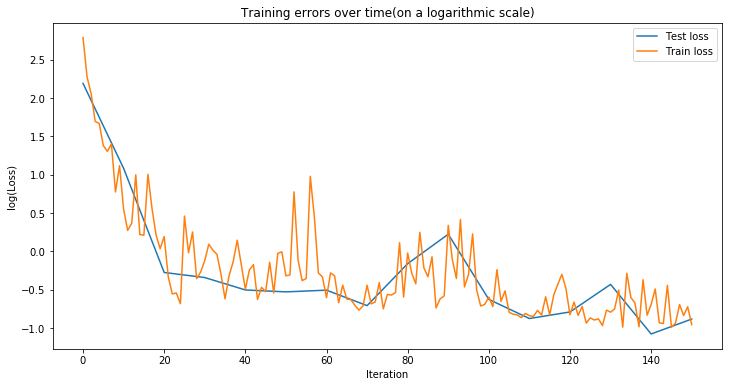

In [13]:
#Визуализация процесса обучения
plt.figure(figsize = (12,6))
plt.plot(
    np.array(range (0,len(test_losses))) / float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),
    label = "Test loss"
)

plt.plot(
    np.log(train_losses),
    label = "Train loss"
)

plt.title("Training errors over time(on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc = 'best')
plt.show()

Let's visualize1 predictions with our signals:


No handles with labels found to put in legend.


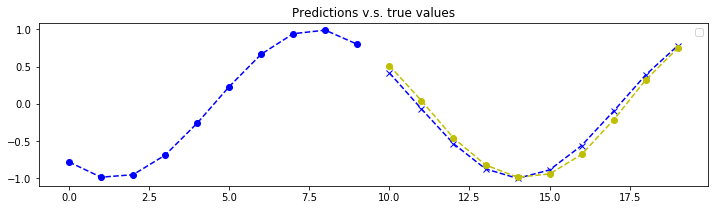

In [19]:
nb_predictions = 1
print ("Let's visualize{} predictions with our signals:".format(nb_predictions))

X,Y = generate_x_y_data_v1(isTrain = False,batch_size = nb_predictions)
feed_dict = {enc_inp[t]:X[t] for t in range (seq_length)}
outputs = np.array(sess.run([reshaped_outputs],feed_dict)[0])

for j in range(nb_predictions):
    plt.figure(figsize = (12,3))
    
    for k in range(output_dim):
        past = X [:,j,k]
        expected = Y [:,j,k]
        pred = outputs [:,j,k]
        
    label1 = "Seen(past) values" if k == 0 else "_nolegend_"
    label2 = "True future values" if k == 0 else "_nolegend_"
    label3 = "Predictions" if k == 0 else "_nolegend_"
    plt.plot(range(len(past)),past,"o--b",label = label1)
    plt.plot(range(len(past),len ( expected )+ len(past)),expected,"x--b",label = label2)
    plt.plot(range(len(past),len ( pred )+ len(past)),pred,"o--y",label = label3)
    
    plt.legend(loc = 'best')
    plt.title("Predictions v.s. true values")
    plt.show()
    
